## `Determinisitic` Interpolator, $I_{\phi}$, Evaluation (`loss functions 101`)
The aim of this notebook is to identify what loss function(s) I should continue with. The loss function is important for the interpolator. We want the images to capture the magnitude of rain whilst being sharp, avoiding any blurriness.

* Evaluate a trained interpolator(s) visually.

* Load in an interpolator and run inference on a chosen split i.e. `'train'`, `'val'` or `'test'`.

* This notebook also computes `VGG`, `LPIPs`,`SSIM`, `MSE(reduction='mean')`, `MSE(reduction='sum')`, `MAE`, `CSI`, `CRPS` and `PSNR` for any model on the `'val'` or `'test'` dataset (or on the `'train'`, any split).

In [ ]:
import os
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from scipy import io
from torch.utils.data import DataLoader
from tqdm import tqdm

from rainnow.src.dyffusion.experiment_types.interpolation import InterpolationExperiment
from rainnow.src.dyffusion.datamodules.imerg_precipitation import IMERGPrecipitationDataModule
from rainnow.src.interpolator_evaluation import (
    eval_trained_interpolators,
    eval_single_trained_interpolator,
)
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.utils import (
    get_device,
)
from rainnow.src.utilities.loading import (
    load_model_checkpoint_for_eval,
    instantiate_interpolator_model_from_base_config,
    instantiate_interpolator_model_ckpt_from_config,
    load_imerg_datamodule_from_config,
)
from rainnow.src.plotting import plot_a_sequence, plot_an_interpolated_sequence

#### `helpers.`

In [10]:
# ** DIR helpers **
BASE_PATH = "/teamspace/studios/this_studio"

CKPT_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/results/interpolation_deterministic_experiments"
CONFIGS_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/src/dyffusion/configs/"

CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = False

# plotting helpers.
cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
# cmap = io.loadmat(f"{BASE_PATH}/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {"font.size": 8}  # , "font.family": "Times New Roman"}
plt_params = {"wspace": 0.1, "hspace": 0.15}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 7.5}

# get device.
device = get_device()

#### `instantiate the dataloaders + get batch of data.`

In [11]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    # experiments done with [1, 0] and dt = 2 (full-sequences).
    overrides={"boxes": ["1,0"], "prediction_horizon": 4, "horizon": 4, "window": 1, "sequence_dt": 2},
)

# datamodule.setup("fit")  # train and val.
# datamodule.setup("validate")
datamodule.setup("test")
datamodule.setup("predict")

[2024-08-17 15:23:19][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-17 15:23:19][imerg_precipitation.py][INFO] --> test data split: [202307010000, 202401010000]
[2024-08-17 15:24:30][torch_datasets.py][INFO] --> creating TEST tensor dataset.
[2024-08-17 15:24:30][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-17 15:24:31][abstract_datamodule.py][INFO] -->  Dataset test size: 763
[2024-08-17 15:24:31][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-17 15:24:31][imerg_precipitation.py][INFO] --> predict data split: [202303070000, 202303090000]
[2024-08-17 15:25:43][torch_datasets.py][INFO] --> creating PREDICT tensor dataset.
[2024-08-17 15:25:43][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-17 15:25:43

In [13]:
# set up the dataloaders.
BATCH_SIZE = datamodule.hparams["batch_size"]
print(f"***  batch size = {BATCH_SIZE} ***")
# train_dataloader = DataLoader(datamodule._data_train, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(datamodule._data_val, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(datamodule._data_test, batch_size=BATCH_SIZE, shuffle=False)
predict_dataloader = DataLoader(datamodule._data_predict, batch_size=BATCH_SIZE, shuffle=False)

iter_loader = iter(predict_dataloader)

# get a batch of data.
X = next(iter_loader)["dynamics"]
X.shape  # (batch_size, sequence_length, channels, H, W)

***  batch size = 6 ***


torch.Size([6, 5, 1, 128, 128])

#### `instantiate PreProcess() object`

In [14]:
# instantiate the pprocessor object.
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

[2024-08-17 15:26:40][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


---------------

## DETERMINISTIC EXPERIMENTS
* Explore the use of different loss functions in a deterministic manner. All dropout was set to `0.0`.

#### `Loss Function Experimental Setup:`

The loss function plays a crucial role in 'good' interpolated images. In order to compare different interpolator loss functions, the following experimental setup was used for varying losses. Unless stated otherwise, these were the params used.

* model = `Unet Resnet`
* number of epochs = `15` 
* lr = `0.001 (1e-3)`
* grid box = `[1, 0]`
* all data is Min Max + Log Linear Normed via `PreProcess()`
* batch size = **6**
* For all pixel-based distance losses (MSEs) the `reduction = 'mean'` unless stated otherwise.
* dropout for entire network is `0.0`. For UNet Resnet this means that block1, block2 and attn dropout are 0.
* the final convlutional layer has a `kernel size = 4`
* `Batchnorm2d()` is used throughout the network. After the input, during each block and after the encoding and decoding layers.


**NOTE**: YOU need to add a model's `ckpt_id` to the `ckpt_dict` for it to work with the evaluation functionality.

In [49]:
# fmt: off
# ckpt_id: <experiment description>
ckpt_dict = {
    # "gjteqrkv": "MSE (SimpleUNet)",
    "tdc1vkym": "MSE",
    "interpolation-8nyusnja": "MAE",
    "qk0hhp3b": "CB(β=1.0)",
    "lxnuzjly": "LCB(α=.9)",                   # γ=1, b=1.0. 
    # "vo9emrq4": "LCB(α=.8)",                   # γ=1, b=1.0. 
    "gr21i3db": "LCB(α=.6)",                   # γ=1, b=1.0. 
    "ipol-gc4bqxib": "LCB(α=.33)",             # CB+LPIPS: α=.33 (1/3), γ=1, b=1.0
    "ipol-bo2579ip": "LCB(α=.1)",              # CB+LPIPS: α=.1, γ=1, b=1.0                      
    # "wejqxftb": "VGGCB(α=.8, γ=1e-3)",         # CB+VGG: α=.8, γ=1e-3, b=1.0
    "kfcqvyrf": "VGGCB(α=.8, γ=1e-2)",         # CB+VGG: α=.8, γ=1e-2, b=1.0
    "6ljvyhnu": "VGGCB(α=.5, γ=1e-2)",         # CB+VGG: α=.5, γ=1e-2, b=1.0
    # "1ykxclrr": "VGGCB(α=.5, γ=1e-3)",         # CB+VGG: α=.5, γ=1e-3, b=1.0
    # "j6jgjb7y": "VGGCB(α=.5, γ=1e-2, β=.1)",   # CB+VGG: α=.5, γ=1e-2, b=.1
    "zvfn48fd": "WL(ε=150.)",
}
# fmt: on

#### `Load in an interpolator model(s) (UNet ResNet or Unet) for evaluation.`

In [75]:
loaded_models = {}
for ckpt_id in ckpt_dict.keys():  # use this if you want to run every experiment.
    print(f"** Getting model from ckpt_id: {ckpt_id} **\n")
    # instantiate.
    model = instantiate_interpolator_model_ckpt_from_config(
        ckpt_id=ckpt_id,
        model_ckpt_cfg_base_path=CKPT_BASE_PATH,
        cfg_base_path=CONFIGS_BASE_PATH,
        model_cfg_name=CKPT_CFG_NAME,
        datamodule_cfg_name=DATAMODULE_CONFIG_NAME,
    )
    # load w&b.
    model = load_model_checkpoint_for_eval(
        model=model, ckpt_id=ckpt_id, ckpt_base_path=CKPT_BASE_PATH, ckpt_dir=CKPT_DIR, get_last=GET_LAST
    )
    loaded_models[ckpt_id] = model

** running inference for model ID: tdc1vkym: MSE **
** running inference for model ID: interpolation-8nyusnja: MAE **
** running inference for model ID: qk0hhp3b: CB(β=1.0) **
** running inference for model ID: gr21i3db: LCB(α=.6) **
** running inference for model ID: kfcqvyrf: VGGCB(α=.8, γ=1e-2) **


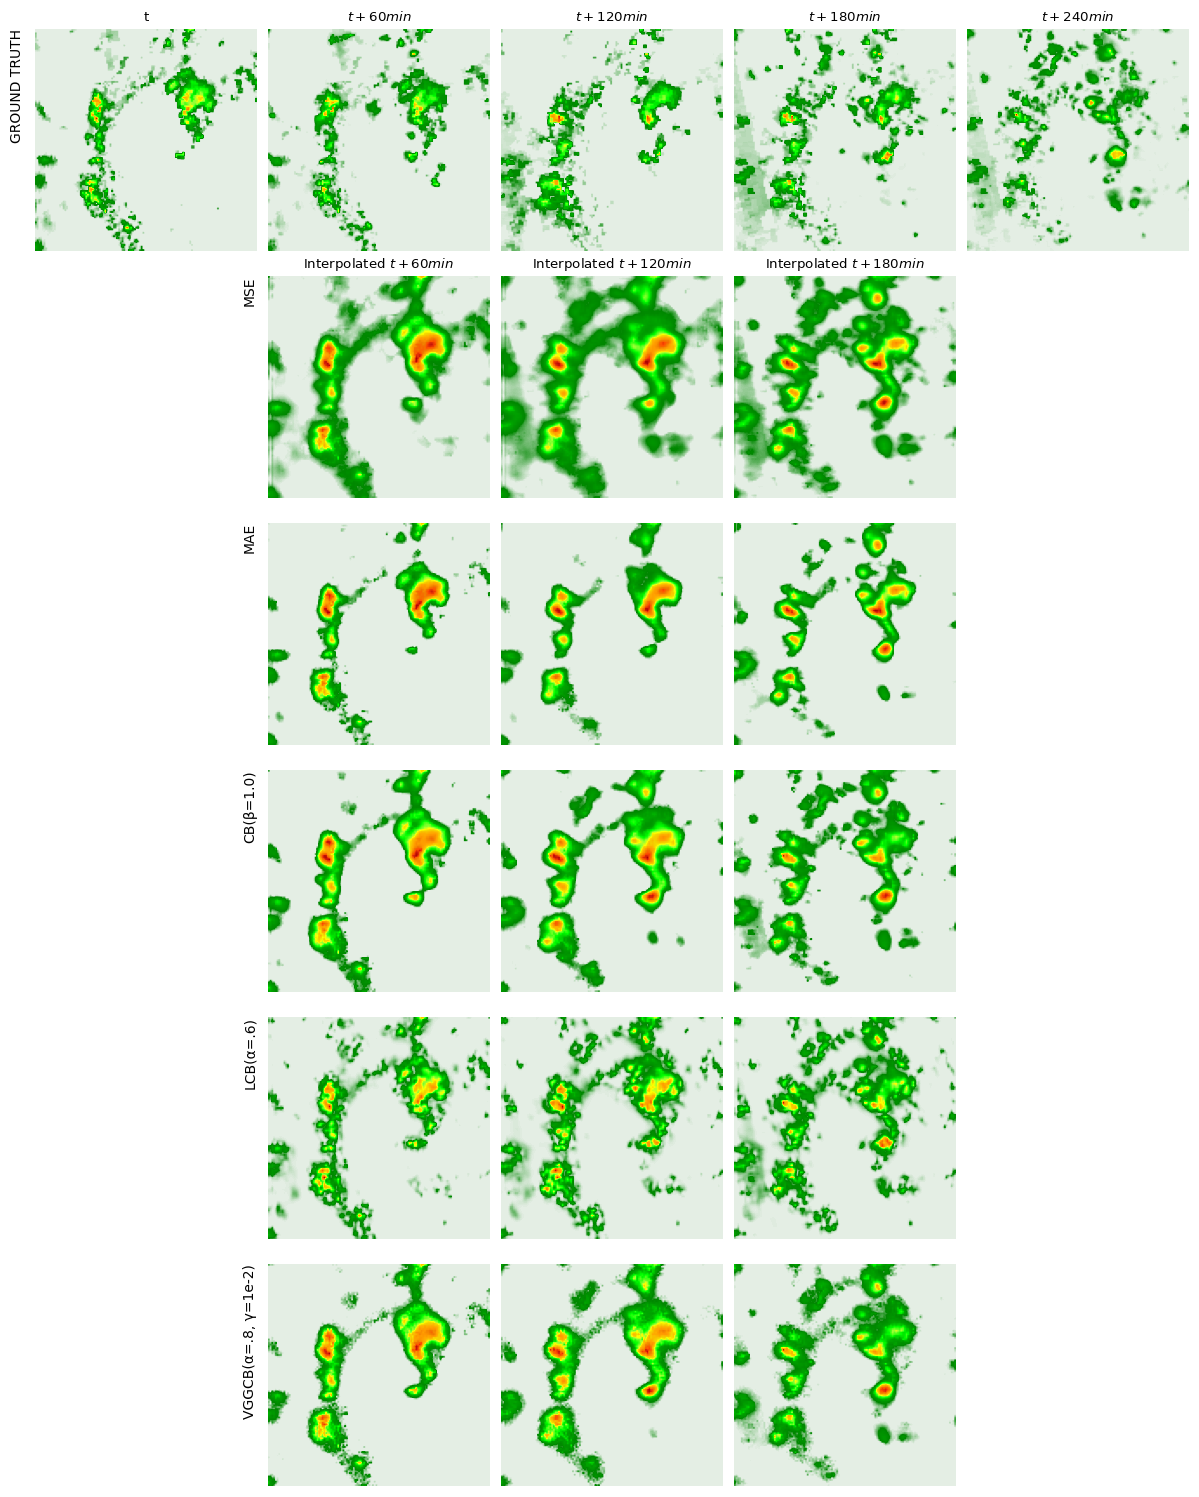

In [74]:
BATCH_NUM_TO_PLOT = 5

# subset loaded models:
ckpt_ids_to_plot = [
    "tdc1vkym",
    "interpolation-8nyusnja",
    "qk0hhp3b",
    "gr21i3db",
    # "ipol-bo2579ip",
    "kfcqvyrf",
]

eval_trained_interpolators(
    X=X,
    # loaded_models=loaded_models,
    loaded_models={k: v for k, v in loaded_models.items() if k in ckpt_ids_to_plot},
    ckpt_dict=ckpt_dict,
    pprocessor_obj=pprocessor,
    batch_num=BATCH_NUM_TO_PLOT,
    channel_to_plot=0,
    cmap=rain_cmap,
    global_params={"font.size": 8},
    plt_params={"wspace": 0.05, "hspace": 0.1},
    ylabel_params={"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 10},
    figsize=(12, 3),
)

In [ ]:
eval_single_trained_interpolator(
    X=X,
    model=loaded_models["gr21i3db"],
    pprocessor_obj=pprocessor,
    channel_to_plot=0,
    cmap=rain_cmap,
    global_params=global_params,
    plt_params={"wspace": 0.05, "hspace": 0.05, "left": 0.3},
    ylabel_params={"ha": "right", "va": "bottom", "fontsize": 8},
    figsize=(12, 1),
)

--------------------

#### `Evaluation Metrics`

* `SSIM`: common image quality score | [0, 1] higher the better.
* `LPIPS`: image perceptual score. Seems much more aligned with human visual perception that `SSIM` | ~ [0, 1] lower the better.
* `VGG`: another image perceptual score.
* `PSNR`: image signal to noise ratio | [0, inf] higher better.
* `MSE`
* `CSI`: a classification measure of how well a model can capture different classes of rainfall at $mm.h{-1}$ at measure how 

In [ ]:
from torch.nn import MSELoss, L1Loss
from torchmetrics.image import (
    StructuralSimilarityIndexMeasure as SSIM,
    PeakSignalNoiseRatio as PSNR,
    LearnedPerceptualImagePatchSimilarity as LPIPS,
)
from torchmetrics.regression import CriticalSuccessIndex

from rainnow.src.loss import VGGLoss

In [ ]:
# instantiate metrics.
ssim = SSIM(data_range=1.0, reduction="elementwise_mean").to(device)
lpips = LPIPS(reduction="mean", normalize=True).to(device)
mse = MSELoss(reduction="mean")
mse_red_sum = MSELoss(reduction="sum")
mae = L1Loss(reduction="mean")
psnr = PSNR(data_range=1.0, reduction="elementwise_mean").to(device)
vgg = VGGLoss(model_name="vgg16", reduction="mean", device=device)

csi_nodes = [2, 10, 18]
# need to get the nodes to the same scale as the data. See NB:  imerg_rainfall_classes.ipynb for rain classes + distributions.
normed_csi_nodes = pprocessor.apply_preprocessing(np.array(csi_nodes))
csi2 = CriticalSuccessIndex(threshold=normed_csi_nodes[0]).to(device)
csi10 = CriticalSuccessIndex(threshold=normed_csi_nodes[1]).to(device)
csi18 = CriticalSuccessIndex(threshold=normed_csi_nodes[-1]).to(device)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


* value (node) to weight for the CB loss and also the CSI metrics:

| Rain Classification | Precipitation Intensity (mm/h) | Node Value | Weight |
|---------------------|--------------------------------|------------|--------|
| No rain             | < 0.5                          | 0.5        | 1      |
| Weak rain           | 0.5-2                          | 2          | 2      |
| Moderate rain       | 2-6                            | 6          | 5      |
| Heavy rain          | 6-10                           | 10         | 10     |
| Very heavy rain     | 10-18                          | 18         | 20     |
| Shower              | 18-30                          | 30         | 30     |
| Cloudburst          | > 30                           | -          | 50     |

`PSNR`
* aim is to keep is relatively the same.

`Pixelwise scores`
* MAE - helps to penalize over predicting 0s.
* MSE - default **DYffusion** metric. Aim is to again keep is relatively similar across losses.

`Perceptual Scores`
Context: 'LPIPS seems to be more aligned / coherent with my visual judgement. SSIM is ~ unchanging and VGG is more akin to SSIM'.
* LPIPS is complex and a deep network that is trained on human perceptual judgments and designed to better capture perceptual similarities between images. This often leads to results that are more aligned with human visual assessment, especially for complex images or those with non-uniform distributions.
* SSIM performs 'badly' for the IMERG rain data. SSIM assumes a Gaussian distribution of pixel intensities. It also primarily focuses on luminance, contrast, and structure, which may not be sufficient for all types of image comparisons - not complex enough.
* VGG seems to be more aligned SSIM. The features extracted from pre-trained VGG networks, which may not always align perfectly with human perception?

`CSI`
* makes sure that out interpolations are still capturing the critial rain behavious, in particular as the thresholds increase. 

#### `Get Metrics for split ('val' or 'test')`

In [ ]:
# model evaluation.
with torch.no_grad():
    results = {}
    for _id in ckpt_dict.keys():
        # need to restart the dataloader for each model
        iter_loader = iter(test_dataloader)

        print(f"Evaluating model {_id}: '{ckpt_dict[_id]}'")
        model = loaded_models[_id].to(device)
        model.eval()

        # reset the losses.
        l2_score = 0
        l2_sum_score = 0
        l1_score = 0  # penalises over pred of 0 mmh-1.
        ssim_score = 0
        psnr_score = 0
        vgg_score = 0
        lpips_score = 0
        csi2_score = 0  # low rain.
        csi10_score = 0  # mid rain.
        csi18_score = 0  # heavy rain.

        # # ** use this if want to check on a smaller sample **
        # num_samples = 1
        # from itertools import islice
        # for input in islice(iter_loader, num_samples):

        for e, _input in tqdm(
            enumerate(iter_loader), total=len(iter_loader), desc=f"Evaluating model {_id}"
        ):
            x = _input["dynamics"].to(device)
            # get x0, xh and targets.
            x0 = x[:, 0, :, :, :].to(device)
            xh = x[:, -1, :, :, :].to(device)
            targets = x[:, 1:-1, :, :, :].to(device)
            # interpolate.
            interp = {}
            for t in range(1, (x.size(1) - 2) + 1):
                interp[f"t{t}"] = model(
                    torch.concat([x0, xh], axis=1).to(device),
                    time=torch.tensor([t], dtype=torch.long).to(device),
                ).to(device)
            # reshape interpolations into shape (B, num_interps, H, W)
            preds = torch.concat([v.unsqueeze(-3).detach() for _, v in interp.items()], axis=1)

            # unnorm tanh activated outputs: [-1, 1] --> [0, 1].
            if str(model.final_conv[1]) == "Tanh()":
                # print(f"** unnorming [-1, 1] --> [0, 1] **")
                preds = (preds + 1) / 2

            # reshape preds and targets for certain loss reqs.
            H, W = 128, 128
            preds_reshaped = preds.reshape(-1, 1, H, W)
            targets_reshaped = targets.reshape(-1, 1, H, W)

            # avg. batch losses:
            l2_score += mse(preds, targets)
            l2_sum_score += mse_red_sum(preds, targets)
            l1_score += mae(preds, targets)
            ssim_score += ssim(preds_reshaped, targets_reshaped)
            psnr_score += psnr(preds_reshaped, targets_reshaped)
            # need to clip to 100% ensure that inputs to LPIPs [0, 1]. The data also needs to be 3 channels for LPIPs.
            lpips_score += lpips(
                torch.clip(preds_reshaped, min=0, max=1).expand(-1, 3, -1, -1),
                torch.clip(targets_reshaped, min=0, max=1).expand(-1, 3, -1, -1),
            )
            vgg_score += vgg(preds_reshaped, targets_reshaped)
            csi2_score += csi2(preds, targets)
            csi10_score += csi10(preds, targets)
            csi18_score += csi18(preds, targets)

        results[_id] = {
            "l2": l2_score.item() / len(iter_loader),
            "l2_sum": l2_sum_score.item() / len(iter_loader),
            "l1": l1_score.item() / len(iter_loader),
            "ssim": ssim_score.item() / len(iter_loader),
            "psnr": psnr_score.item() / len(iter_loader),
            "vgg": vgg_score.item() / len(iter_loader),
            "lpips": lpips_score.item() / len(iter_loader),
            "csi2": csi2_score.item() / len(iter_loader),
            "csi10": csi10_score.item() / len(iter_loader),
            "csi18": csi18_score.item() / len(iter_loader),
        }

    # create df, format it and export it to a .csv.
    df_results = pd.DataFrame(results)
    df_results_formatted = pd.DataFrame(results).rename(columns=ckpt_dict)
    df_results_formatted.to_csv("results/interpolator_deterministic_exp_metrics.csv")
    df_results_formatted

Evaluating model tdc1vkym: 'MSE'


Evaluating model tdc1vkym: 100%|██████████| 126/126 [00:42<00:00,  2.99it/s]


Evaluating model interpolation-8nyusnja: 'MAE'


Evaluating model interpolation-8nyusnja: 100%|██████████| 126/126 [00:40<00:00,  3.08it/s]


Evaluating model qk0hhp3b: 'CB(β=1.0)'


Evaluating model qk0hhp3b: 100%|██████████| 126/126 [00:44<00:00,  2.86it/s]


Evaluating model lxnuzjly: 'LCB(α=.9)'


Evaluating model lxnuzjly: 100%|██████████| 126/126 [00:43<00:00,  2.87it/s]


Evaluating model gr21i3db: 'LCB(α=.6)'


Evaluating model gr21i3db: 100%|██████████| 126/126 [00:44<00:00,  2.85it/s]


Evaluating model ipol-gc4bqxib: 'LCB(α=.33)'


Evaluating model ipol-gc4bqxib: 100%|██████████| 126/126 [00:44<00:00,  2.82it/s]


Evaluating model ipol-bo2579ip: 'LCB(α=.1)'


Evaluating model ipol-bo2579ip: 100%|██████████| 126/126 [00:37<00:00,  3.39it/s]


Evaluating model kfcqvyrf: 'VGGCB(α=.8, γ=1e-2)'


Evaluating model kfcqvyrf: 100%|██████████| 126/126 [00:31<00:00,  3.94it/s]


Evaluating model 6ljvyhnu: 'VGGCB(α=.5, γ=1e-2)'


Evaluating model 6ljvyhnu: 100%|██████████| 126/126 [00:45<00:00,  2.80it/s]


Evaluating model zvfn48fd: 'WL(ε=150.)'


Evaluating model zvfn48fd: 100%|██████████| 126/126 [00:44<00:00,  2.81it/s]


In [ ]:
df_results_formatted.T

,l2,l2_sum,l1,ssim,psnr,vgg,lpips,csi2,csi10,csi18
MSE,0.000735,215.458922,0.008969,0.832566,31.814126,1.406906,0.271582,0.354604,0.134554,0.048660
MAE,0.000791,231.997582,0.007860,0.842625,31.472978,1.387827,0.253027,0.325152,0.117249,0.034655
CB(β=1.0),0.001138,333.972749,0.010939,0.824808,30.004858,1.595399,0.212396,0.359431,0.202254,0.114275
LCB(α=.9),0.001031,302.484313,0.010433,0.817558,30.391005,1.624597,0.124557,0.355217,0.188371,0.080668
LCB(α=.6),0.001021,299.656436,0.010419,0.814098,30.427562,1.629336,0.117103,0.352676,0.191768,0.102316
LCB(α=.33),0.000950,278.792163,0.009733,0.819092,30.711523,1.622467,0.114868,0.339428,0.175261,0.083397
LCB(α=.1),0.000948,278.182447,0.009894,0.815851,30.703976,1.632123,0.115582,0.326623,0.153862,0.069273
"VGGCB(α=.8, γ=1e-2)",0.001135,333.215340,0.010672,0.830907,30.064924,1.400583,0.211533,0.362337,0.200787,0.114658
"VGGCB(α=.5, γ=1e-2)",0.001052,308.948258,0.010429,0.832352,30.370487,1.272929,0.209082,0.366502,0.202080,0.113592
WL(ε=150.),0.000927,271.818979,0.009660,0.816631,30.735005,1.674099,0.140969,0.347520,0.179789,0.104567


* $alpha$ > .6 is the 'winner' along with WL($epsilon$=150.)

In [ ]:
df_results_formatted.T[["l2", "l2_sum", "lpips", "csi2", "csi10", "csi18"]]

,l2,l2_sum,lpips,csi2,csi10,csi18
MSE,0.000735,215.458922,0.271582,0.354604,0.134554,0.048660
MAE,0.000791,231.997582,0.253027,0.325152,0.117249,0.034655
CB(β=1.0),0.001138,333.972749,0.212396,0.359431,0.202254,0.114275
LCB(α=.9),0.001031,302.484313,0.124557,0.355217,0.188371,0.080668
LCB(α=.6),0.001021,299.656436,0.117103,0.352676,0.191768,0.102316
LCB(α=.33),0.000950,278.792163,0.114868,0.339428,0.175261,0.083397
LCB(α=.1),0.000948,278.182447,0.115582,0.326623,0.153862,0.069273
"VGGCB(α=.8, γ=1e-2)",0.001135,333.215340,0.211533,0.362337,0.200787,0.114658
"VGGCB(α=.5, γ=1e-2)",0.001052,308.948258,0.209082,0.366502,0.202080,0.113592
WL(ε=150.),0.000927,271.818979,0.140969,0.347520,0.179789,0.104567


In [ ]:
# plot an example sequence that losses computed on.
plot_a_sequence(X=x.cpu().detach(), b=0, global_params=global_params, cmap=rain_cmap, c=0)
plot_an_interpolated_sequence(
    x0=x0.cpu().detach(),
    x_interp=preds.cpu().detach(),
    xh=xh.cpu().detach(),
    b=0,
    global_params=global_params,
    cmap=rain_cmap,
    c=0,
    plot_start_end=False,
)

#### END OF SCRIPT.